# Soil Fertility Analysis using Random Forest Models

This notebook implements both Random Forest Classifier and Regressor models for soil fertility analysis using various soil parameters such as N, P, K, EC, and Fe content.

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import (accuracy_score, classification_report, mean_squared_error, 
                           r2_score, confusion_matrix, roc_curve, auc,
                           precision_recall_curve, average_precision_score)

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Set random seed for reproducibility
np.random.seed(42)

## Data Loading and Exploration

Let's load our dataset and perform some initial exploratory data analysis.

In [50]:

df = pd.read_csv('../Datasets/dataset_1.csv')

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

print("\nFirst few rows:")
print(df.head())

print("\nSummary statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       880 non-null    int64  
 1   P       880 non-null    float64
 2   K       880 non-null    int64  
 3   EC      880 non-null    float64
 4   Fe      880 non-null    float64
 5   Output  880 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 41.4 KB
None

First few rows:
     N    P    K    EC    Fe  Output
0  138  8.6  560  0.62  0.31       0
1  213  7.5  338  0.75  0.86       0
2  163  9.6  718  0.51  0.86       0
3  157  6.8  475  0.58  0.54       0
4  270  9.9  444  0.40  0.76       1

Summary statistics:
               N           P           K          EC          Fe      Output
count  880.00000  880.000000  880.000000  880.000000  880.000000  880.000000
mean   246.73750   14.562159  499.978409    0.543659    4.140523    0.588636
std     77.38886   21.967755  124.22283

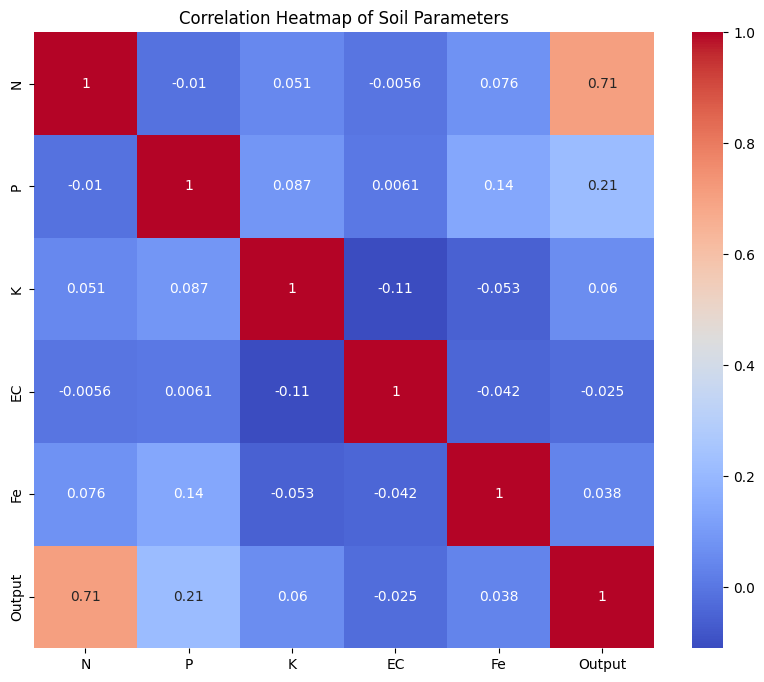

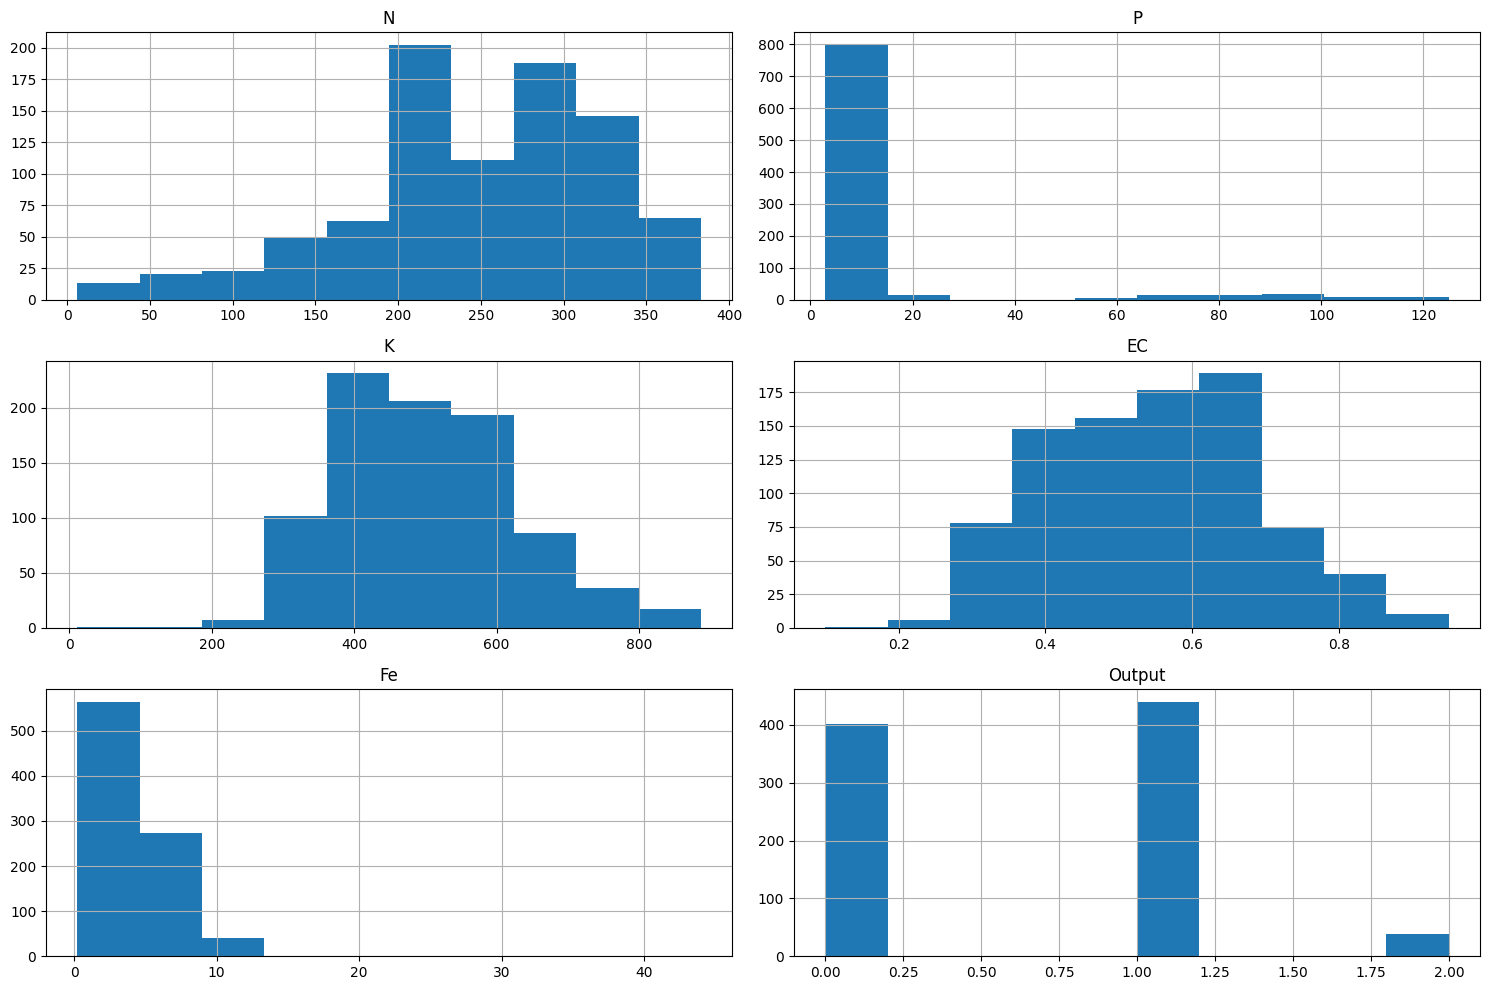

In [51]:
# Separate features and target
X = df.drop('Output', axis=1)
y = df['Output']

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Soil Parameters')
plt.show()

# Distribution of features
df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

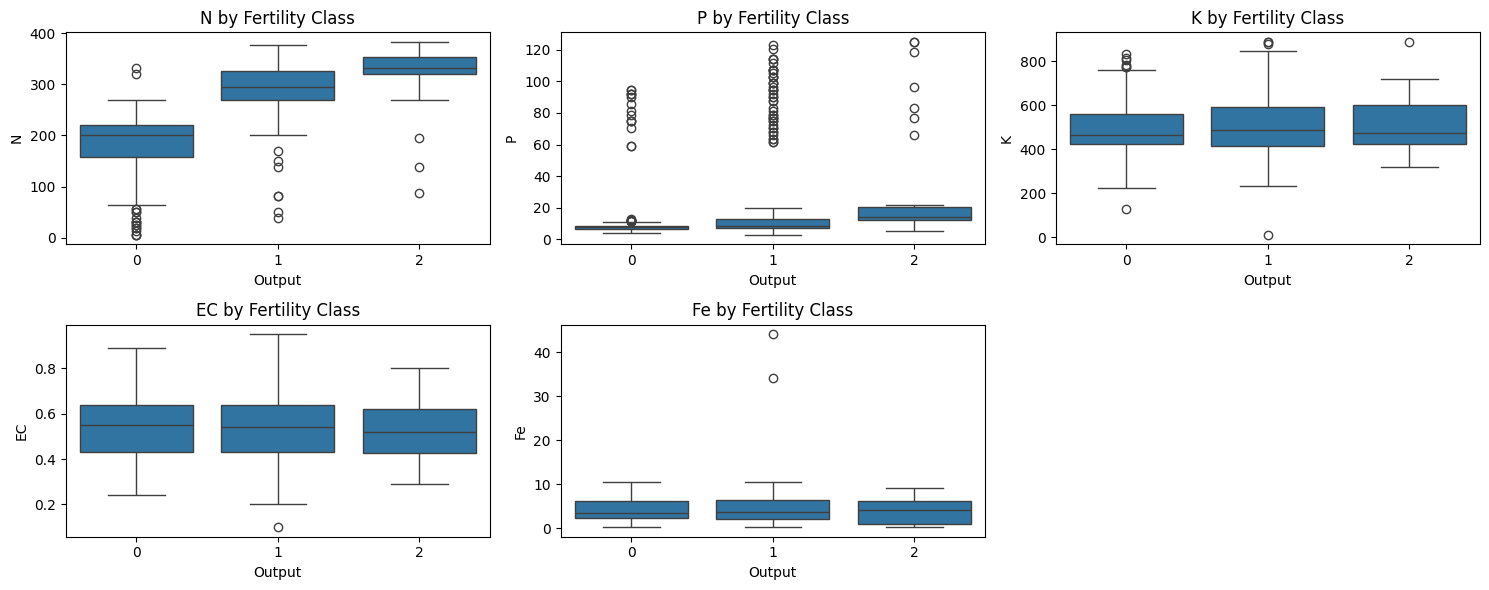

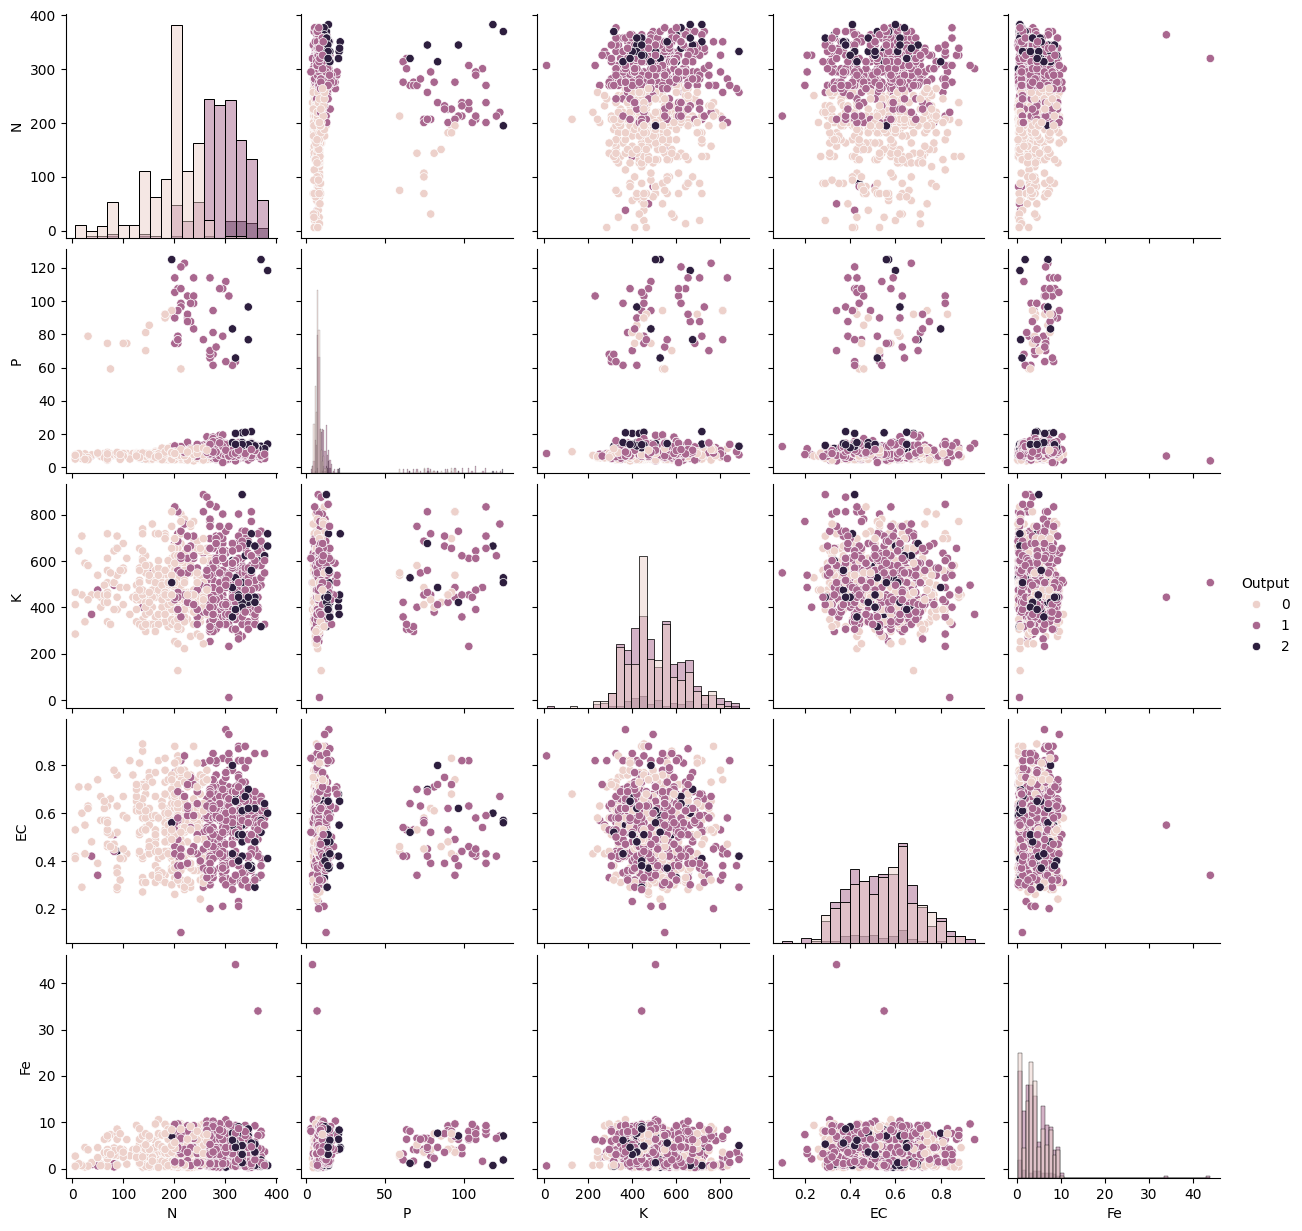

In [52]:
# Box plots for feature distributions by class
plt.figure(figsize=(15, 6))
for i, column in enumerate(X.columns):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Output', y=column, data=df)
    plt.title(f'{column} by Fertility Class')
plt.tight_layout()
plt.show()

# Pair plot for feature relationships
sns.pairplot(df, hue='Output', diag_kind='hist')
plt.show()

In [53]:
# Separate features and target
X = df.drop('Output', axis=1)
y = df['Output']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Training set shape: (704, 5)
Testing set shape: (176, 5)

Class distribution in training set:
Output
1    0.500000
0    0.458807
2    0.041193
Name: proportion, dtype: float64

Class distribution in test set:
Output
1    0.500000
0    0.443182
2    0.056818
Name: proportion, dtype: float64


## Data Preprocessing

Let's scale our features and perform initial cross-validation to establish a baseline.

In [54]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initial cross-validation for classifier
base_clf = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(base_clf, X_scaled, y, cv=5)

print("Cross-validation scores (Classifier):", cv_scores)
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-validation scores (Classifier): [0.90340909 0.93181818 0.90340909 0.875      0.77272727]
Mean CV Score: 0.8773 (+/- 0.1105)


## Random Forest Classifier

First, let's train and evaluate a Random Forest Classifier for predicting soil fertility class.

In [55]:
# Define focused parameter grid for efficiency
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Perform GridSearchCV
grid_clf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

grid_clf.fit(X_train_scaled, y_train)

print("Best parameters:", grid_clf.best_params_)
print("Best cross-validation score:", grid_clf.best_score_)

# Use best model for final evaluation
best_clf = grid_clf.best_estimator_

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best cross-validation score: 0.9162310030395137


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        78
           1       0.89      0.88      0.88        88
           2       1.00      0.40      0.57        10

    accuracy                           0.88       176
   macro avg       0.92      0.74      0.79       176
weighted avg       0.89      0.88      0.87       176



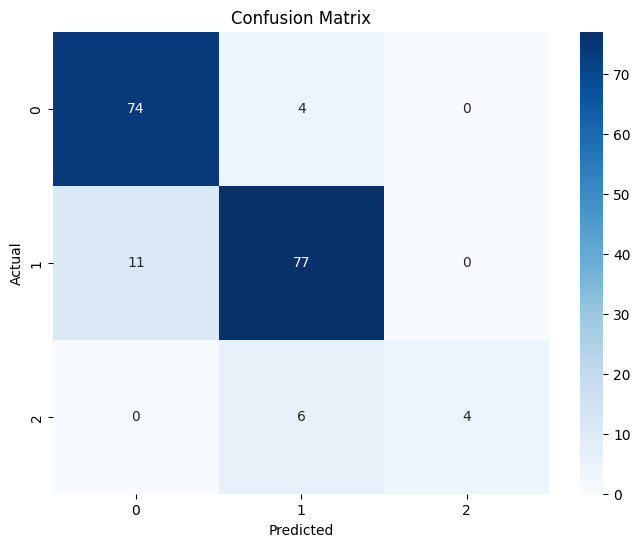

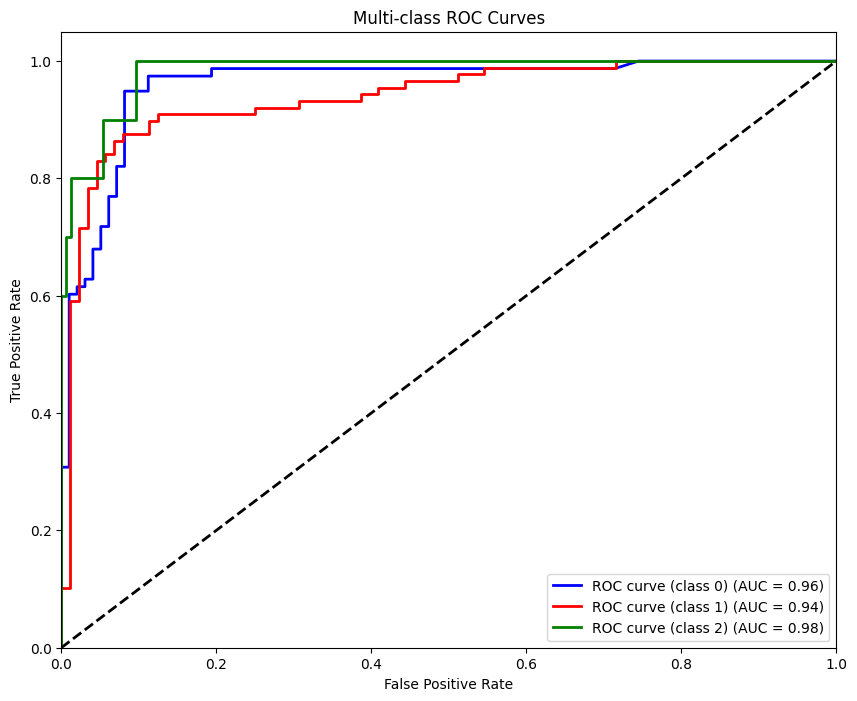

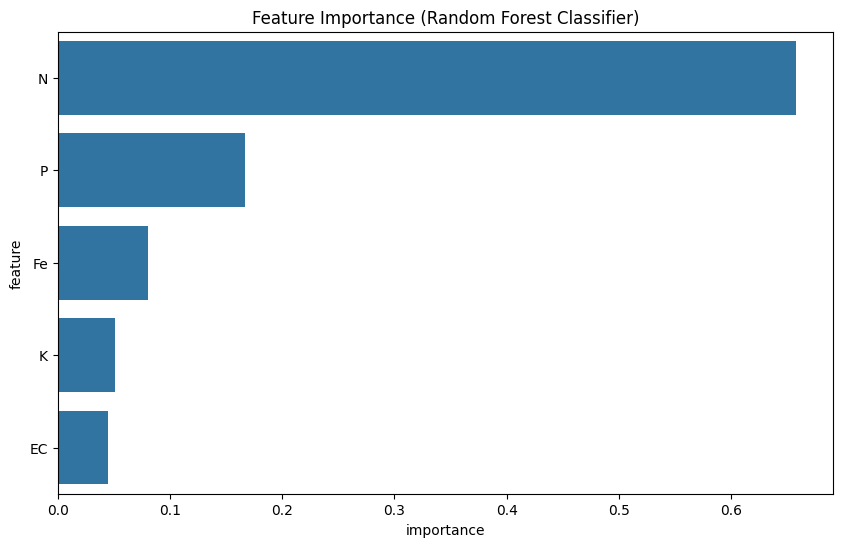

In [56]:
# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions with best model
y_pred_clf = best_clf.predict(X_test_scaled)

# Print classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_clf))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Get unique classes
n_classes = len(np.unique(y))

# Convert labels to binary format
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# Get probability predictions
y_score = best_clf.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']  # Add more colors if needed

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc='lower right')
plt.show()

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_clf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Random Forest Classifier)')
plt.show()

## Random Forest Regressor

Now, let's implement a Random Forest Regressor to predict continuous values for soil fertility.

Regression Metrics:
Mean Squared Error: 0.1055
Root Mean Squared Error: 0.3248
Mean Absolute Error: 0.1565
R2 Score: 0.6993


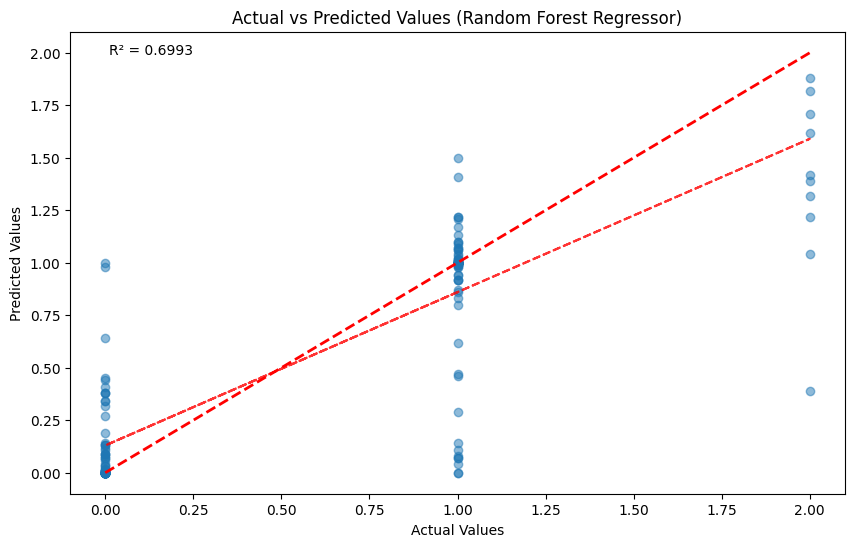

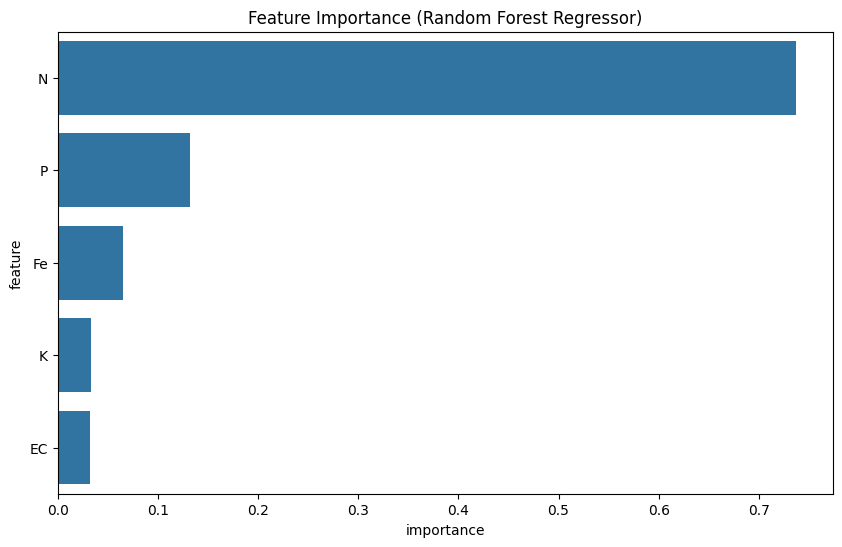

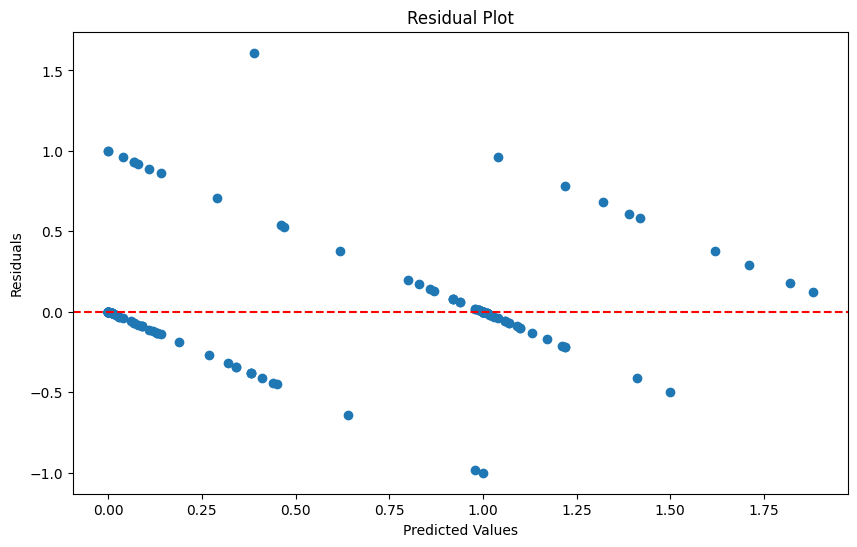

In [57]:
# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_scaled, y_train)

# Make predictions
y_pred_reg = rf_regressor.predict(X_test_scaled)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred_reg)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test - y_pred_reg))
r2 = r2_score(y_test, y_pred_reg)

print("Regression Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

# Plot actual vs predicted values with confidence intervals
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted
plt.scatter(y_test, y_pred_reg, alpha=0.5)

# Perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

# Add confidence intervals
z = np.polyfit(y_test, y_pred_reg, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), "r--", alpha=0.8)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Random Forest Regressor)')

# Add R² value to plot
plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes)
plt.show()

# Plot feature importance for regressor
feature_importance_reg = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_regressor.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_reg)
plt.title('Feature Importance (Random Forest Regressor)')
plt.show()

# Plot residuals
residuals = y_test - y_pred_reg
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_reg, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## Save Models

Let's save both models for later use in the application layer.

Models, scaler, and feature importance rankings have been saved successfully!


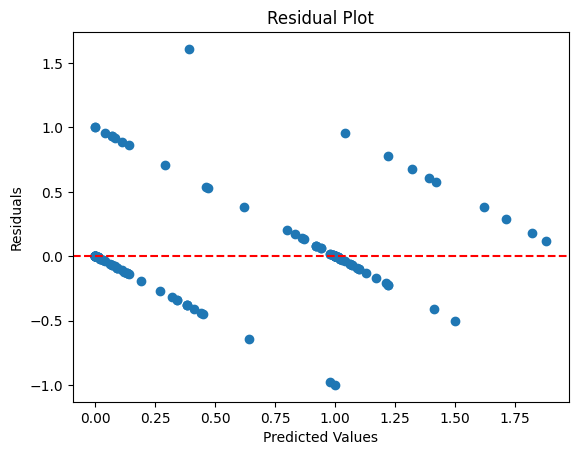

<Figure size 1000x600 with 0 Axes>

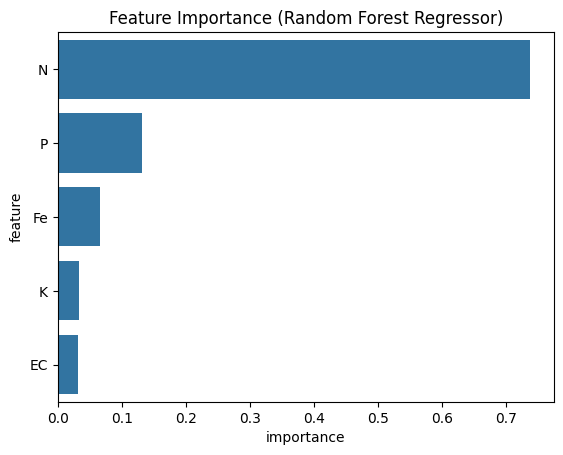

<Figure size 1000x600 with 0 Axes>

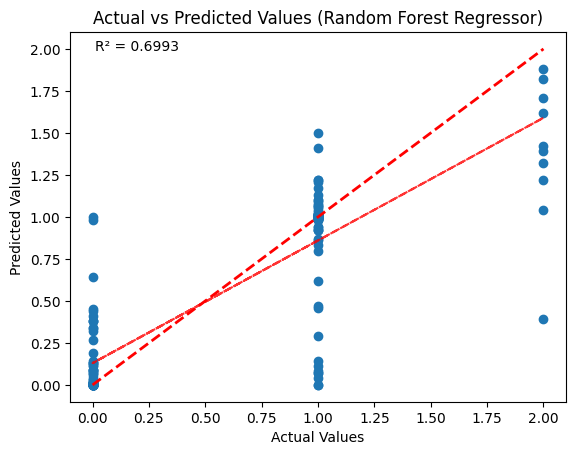

R2 Score: 0.6993
Mean Absolute Error: 0.1565
Root Mean Squared Error: 0.3248
Mean Squared Error: 0.1055
Regression Metrics:
Classification Report:


/tmp/ipykernel_2113/1479697003.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


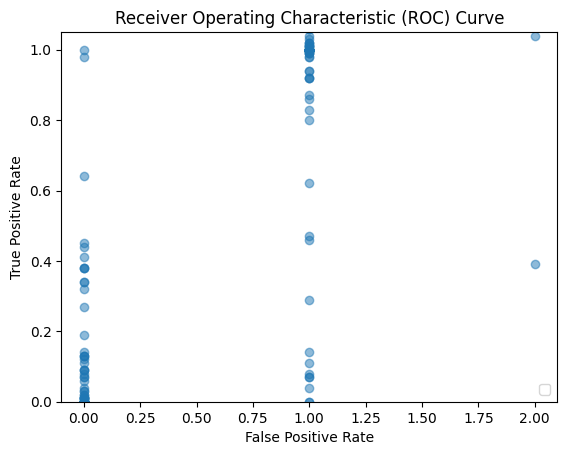

<Figure size 1000x600 with 0 Axes>

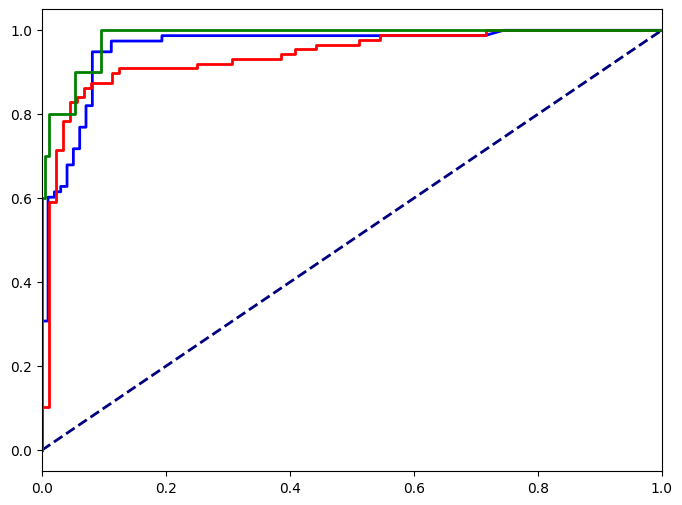

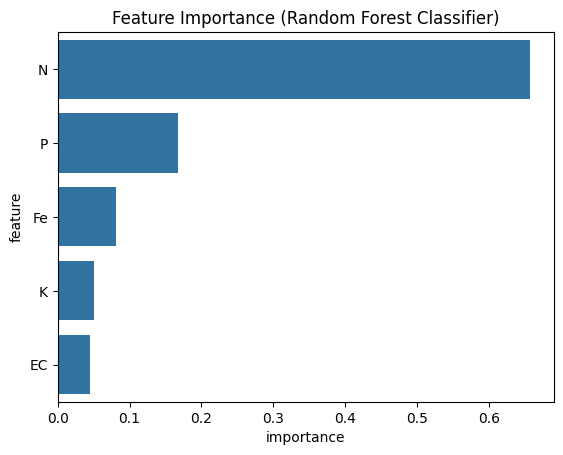

<Figure size 1000x600 with 0 Axes>

              precision    recall  f1-score   support

           0       0.87      0.95      0.91        78
           1       0.89      0.88      0.88        88
           2       1.00      0.40      0.57        10

    accuracy                           0.88       176
   macro avg       0.92      0.74      0.79       176
weighted avg       0.89      0.88      0.87       176



<Figure size 800x600 with 0 Axes>

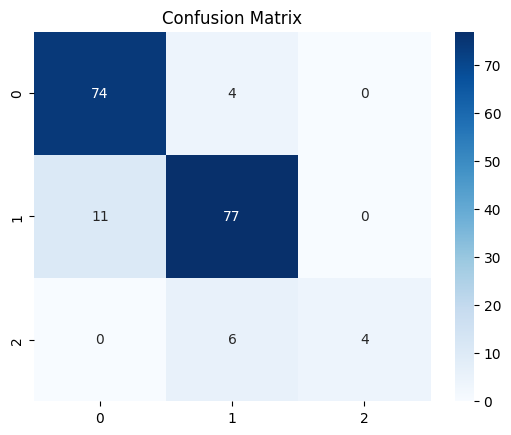

<Figure size 800x600 with 0 Axes>

In [58]:
# Save the models and scaler
joblib.dump(best_clf, '../Models/soil_fertility_classifier.joblib')
joblib.dump(rf_regressor, '../Models/soil_fertility_regressor.joblib')
joblib.dump(scaler, '../Models/feature_scaler.joblib')

# Save feature importance rankings
feature_importance.to_csv('../Models/classifier_feature_importance.csv', index=False)
feature_importance_reg.to_csv('../Models/regressor_feature_importance.csv', index=False)

print("Models, scaler, and feature importance rankings have been saved successfully!")

plt.show()
plt.title('Residual Plot')
plt.ylabel('Residuals')
plt.xlabel('Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.scatter(y_pred_reg, residuals)
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred_reg


# Plot residuals
plt.show()
plt.title('Feature Importance (Random Forest Regressor)')
sns.barplot(x='importance', y='feature', data=feature_importance_reg)
plt.figure(figsize=(10, 6))
feature_importance_reg = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_regressor.feature_importances_
}).sort_values('importance', ascending=False)


# Plot feature importance for regressor
plt.show()
plt.scatter(y_test, y_pred_reg)
plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes)


# Add R² value to plot
plt.title('Actual vs Predicted Values (Random Forest Regressor)')
plt.ylabel('Predicted Values')
plt.xlabel('Actual Values')
plt.plot(y_test, p(y_test), "r--", alpha=0.8)
p = np.poly1d(z)
z = np.polyfit(y_test, y_pred_reg, 1)


# Add confidence intervals
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)


plt.show()
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.ylabel('True Positive Rate')


# Perfect prediction line

plt.xlabel('False Positive Rate')
plt.ylim([0.0, 1.05])
plt.scatter(y_test, y_pred_reg, alpha=0.5)

# Scatter plot of actual vs predicted
plt.figure(figsize=(10, 6))

# Plot actual vs predicted values with confidence intervals
print(f"R2 Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print("Regression Metrics:")
mae = np.mean(np.abs(y_test - y_pred_reg))
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_reg)
mse = mean_squared_error(y_test, y_pred_reg)

# Calculate regression metrics
y_pred_reg = rf_regressor.predict(X_test_scaled)

# Make predictions with best model
y_pred_clf = best_clf.predict(X_test_scaled)
y_pred_proba = best_clf.predict_proba(X_test_scaled)[:, 1]



# Calculate ROC curve for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve class {i} (AUC = {roc_auc[i]:.2f})')
plt.xlim([0.0, 1.0])


# Print classification metrics
print("Classification Report:")

from sklearn.metrics import roc_curve, auc
# Plot ROC curve

plt.show()
plt.title('Feature Importance (Random Forest Classifier)')
sns.barplot(x='importance', y='feature', data=feature_importance)

plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_clf.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.show()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
print(classification_report(y_test, y_pred_clf))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
cm = confusion_matrix(y_test, y_pred_clf)
# Plot confusion matrix
plt.figure(figsize=(8, 6))

In [59]:
# Example prediction
sample_input = pd.DataFrame({
    'N': [200],
    'P': [8.0],
    'K': [500],
    'EC': [0.5],
    'Fe': [0.6]
})

# Scale the input
sample_input_scaled = scaler.transform(sample_input)

# Make predictions
clf_pred = best_clf.predict(sample_input_scaled)
clf_prob = best_clf.predict_proba(sample_input_scaled)
reg_pred = rf_regressor.predict(sample_input_scaled)

print("\nExample Prediction:")
print("Input Features:")
print(sample_input)
print("\nClassifier Prediction (Class):", clf_pred[0])
print("Classifier Prediction (Probabilities):")
for i, prob in enumerate(clf_prob[0]):
    print(f"Class {i}: {prob:.4f}")
print("\nRegressor Prediction (Continuous):", reg_pred[0])


Example Prediction:
Input Features:
     N    P    K   EC   Fe
0  200  8.0  500  0.5  0.6

Classifier Prediction (Class): 0
Classifier Prediction (Probabilities):
Class 0: 0.9274
Class 1: 0.0692
Class 2: 0.0033

Regressor Prediction (Continuous): 0.05


## Model Comparison and Final Results

Let's compare the performance of both models and summarize our findings.

In [60]:
# Print final summary
print("Random Forest Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_clf):.4f}")

# Print AUC-ROC for each class
for i in range(n_classes):
    print(f"AUC-ROC (Class {i}): {roc_auc[i]:.4f}")

print("\nTop 3 Important Features (Classifier):")
print(feature_importance.head(3))

print("\nRandom Forest Regressor Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print("\nTop 3 Important Features (Regressor):")
print(feature_importance_reg.head(3))

Random Forest Classifier Performance:
Accuracy: 0.8807
AUC-ROC (Class 0): 0.9603
AUC-ROC (Class 1): 0.9396
AUC-ROC (Class 2): 0.9831

Top 3 Important Features (Classifier):
  feature  importance
0       N    0.657789
1       P    0.166713
4      Fe    0.080432

Random Forest Regressor Performance:
R² Score: 0.6993
RMSE: 0.3248

Top 3 Important Features (Regressor):
  feature  importance
0       N    0.737019
1       P    0.132011
4      Fe    0.065156
